In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'real-vs-fake-faces:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2144922%2F3575857%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240429%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240429T045057Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1b505a0da04dedea14b172c03f7210b1b2b9a3da4f716912e45025a12bec5f8ea4bd8f27ad5beabe2adeee5483b9a8886cf62ce9d401aee1fe836cc9749c8f439c22b1444b5a9e03ef622dc0bd92f324efbc5eb9449d443c764821a0a6aee87ac305f5b266e5612eba32097553bf40e33eabf45163cf26a7a442cce7734523ee867bc6e2a67721676e1f56e0c3e80cf432e4582ab0876a4f43aadc5f900c1c3f273efc5f9d351f7062979804323c557e99d9e7d5752d3355838b4df38360f810a3b832e10fea72eabc660d9b18e7c91ac77eb739a742eb1d2ace6776317a1959983a05a877e6d8b7133d8f9d746a5a17905eb73a97ed373ec706f604aeb792a6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 225880406 bytes downloaded
Downloaded and uncompressed: real-vs-fake-faces
Data source import complete.


In [ ]:

import numpy as np
import pandas as pd
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

from tqdm.notebook import tqdm_notebook as tqdm

import os

In [ ]:

print(os.listdir("../input"))

['real-vs-fake-faces']


In [ ]:

real = "../input/real-vs-fake-faces/real/"
fake = "../input/real-vs-fake-faces/fake/"

real_path = os.listdir(real)
fake_path = os.listdir(fake)

In [ ]:

def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

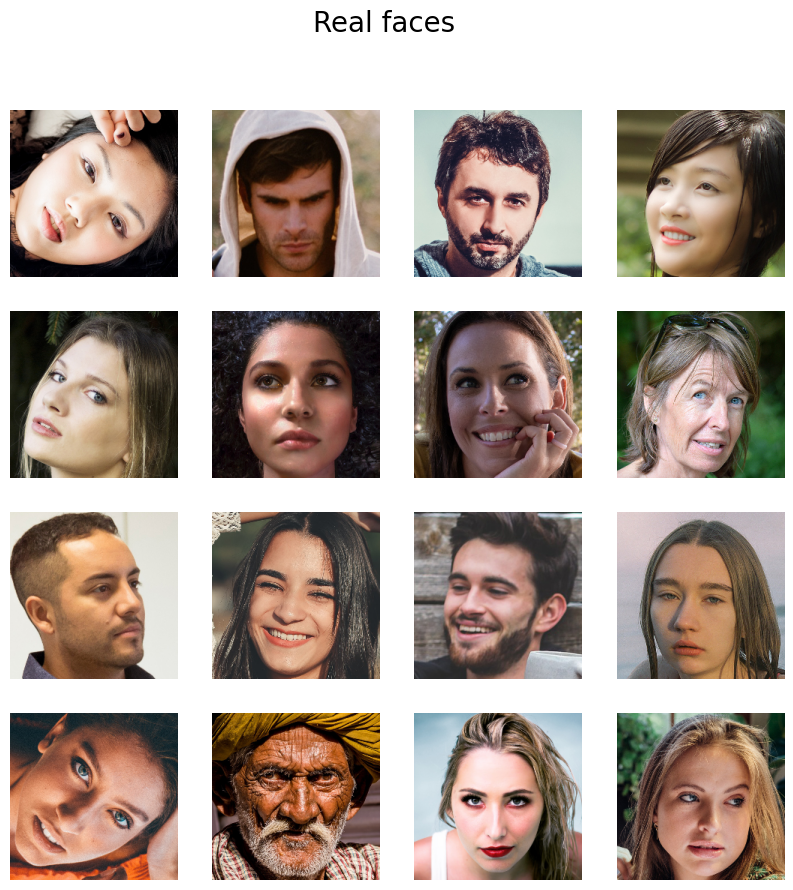

In [ ]:

fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(real + real_path[i]), cmap='gray')
    plt.suptitle("Real faces",fontsize=20)
    plt.axis('off')

plt.show()

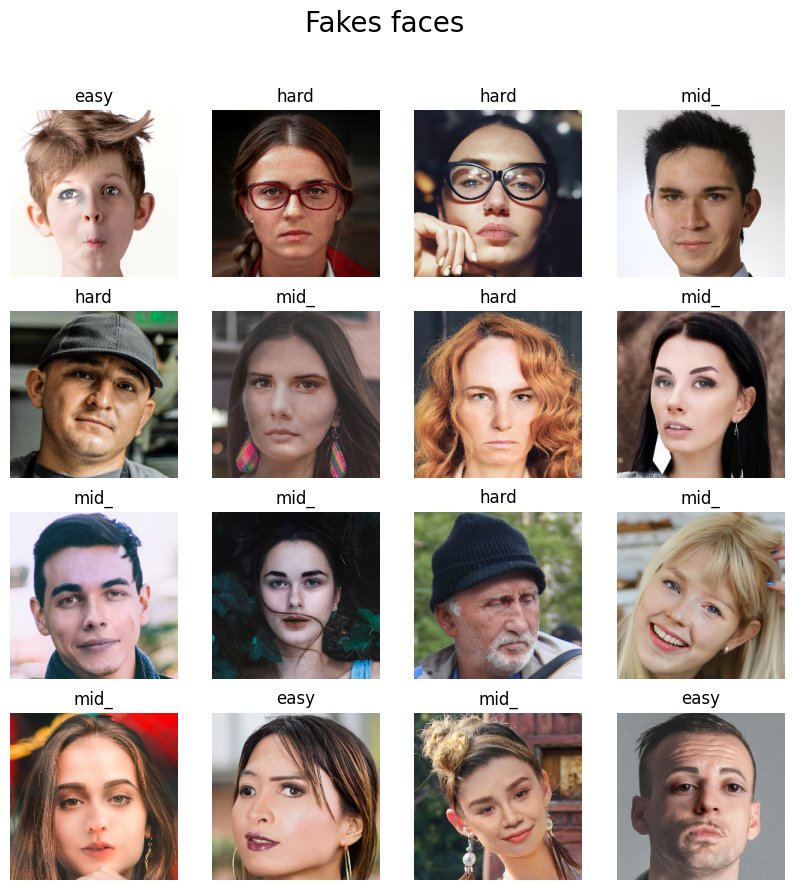

In [ ]:

fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(fake + fake_path[i]), cmap='gray')
    plt.suptitle("Fakes faces",fontsize=20)
    plt.title(fake_path[i][:4])
    plt.axis('off')

plt.show()

In [ ]:

dataset_path = "/kaggle/input/real-vs-fake-faces"

In [ ]:

data_with_aug = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                  validation_split=0.3)

In [ ]:

train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="training")

Found 1429 images belonging to 2 classes.


In [ ]:

val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="validation"
                                          )

Found 612 images belonging to 2 classes.


In [ ]:

mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(96,96,3))

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:

tf.keras.backend.clear_session()

model1 = Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(512, activation = "relu"),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(128, activation = "relu"),
                    Dropout(0.1),
                    # Dense(32, activation = "relu"),
                    # Dropout(0.3),
                    Dense(2, activation = "sigmoid")])

model1.layers[0].trainable = False

model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

model1.summary()
Model1: "sequential"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [ ]:

def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
hist = model1.fit_generator(train,
                    epochs=10,
                    callbacks=[lr_callbacks],
                    validation_data=val)

<ipython-input-13-5d26e7644c39>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model1.fit_generator(train,


Epoch 1/10
45/45 [==============================] - 27s 400ms/step - loss: 0.8638 - accuracy: 0.5934 - val_loss: 0.8205 - val_accuracy: 0.5261 - lr: 0.0010
Epoch 2/10
45/45 [==============================] - 17s 373ms/step - loss: 0.5598 - accuracy: 0.7306 - val_loss: 0.8995 - val_accuracy: 0.5261 - lr: 0.0010
Epoch 3/10
45/45 [==============================] - 17s 379ms/step - loss: 0.4541 - accuracy: 0.7803 - val_loss: 1.0094 - val_accuracy: 0.5245 - lr: 0.0010
Epoch 4/10
45/45 [==============================] - 17s 372ms/step - loss: 0.3693 - accuracy: 0.8418 - val_loss: 0.9817 - val_accuracy: 0.5278 - lr: 1.0000e-04
Epoch 5/10
45/45 [==============================] - 17s 372ms/step - loss: 0.3260 - accuracy: 0.8551 - val_loss: 0.9603 - val_accuracy: 0.5131 - lr: 1.0000e-04
Epoch 6/10
45/45 [==============================] - 22s 493ms/step - loss: 0.3039 - accuracy: 0.8789 - val_loss: 0.9781 - val_accuracy: 0.5261 - lr: 1.0000e-04
Epoch 7/10
45/45 [==============================] - 

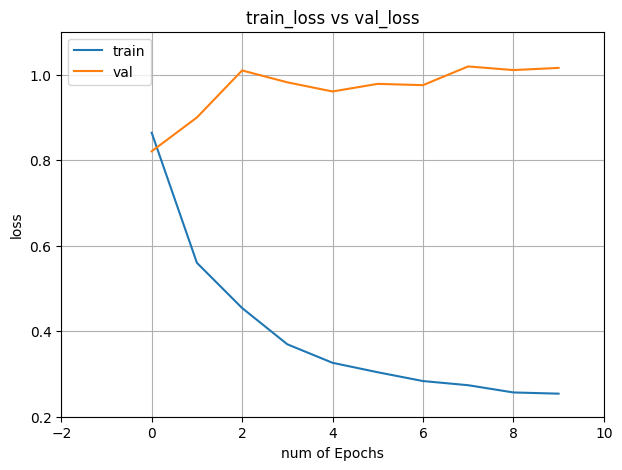

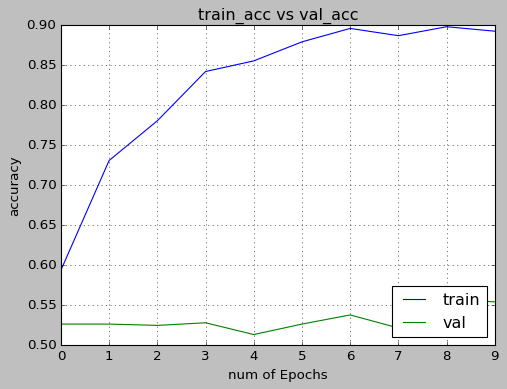

In [ ]:

epochs = 10
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])

In [ ]:
predictions = model1.predict_generator(val)

<ipython-input-15-4301dc0ed728>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model1.predict_generator(val)


In [ ]:
model1.save('mobilenetv2_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="training")

val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="validation"
                                          )

Found 1429 images belonging to 2 classes.
Found 612 images belonging to 2 classes.


In [ ]:

vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:

vgg16_model.output[-1]

<KerasTensor: shape=(7, 7, 512) dtype=float32 (created by layer 'tf.__operators__.getitem')>

In [ ]:



model = Sequential([vgg16_model,
                    Flatten(),

                    Dense(2, activation = "sigmoid")])

model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2)                 50178     
                                                                 
Total params: 14764866 (56.32 MB)
Trainable params: 50178 (196.01 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:

hist =  model.fit_generator(train,
                    epochs=5,
                    callbacks=[lr_callbacks],
                    validation_data=val)

<ipython-input-16-ea3365b6907f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist =  model.fit_generator(train,


Epoch 1/5
15/15 [==============================] - 53s 2s/step - loss: 1.5516 - accuracy: 0.5164 - val_loss: 0.8445 - val_accuracy: 0.5523 - lr: 0.0010
Epoch 2/5
15/15 [==============================] - 22s 2s/step - loss: 0.6557 - accuracy: 0.6746 - val_loss: 0.7988 - val_accuracy: 0.5752 - lr: 0.0010
Epoch 3/5
15/15 [==============================] - 22s 2s/step - loss: 0.5006 - accuracy: 0.7586 - val_loss: 0.7573 - val_accuracy: 0.5752 - lr: 0.0010
Epoch 4/5
15/15 [==============================] - 22s 1s/step - loss: 0.4595 - accuracy: 0.7971 - val_loss: 0.7719 - val_accuracy: 0.5703 - lr: 1.0000e-04
Epoch 5/5
15/15 [==============================] - 22s 1s/step - loss: 0.4558 - accuracy: 0.7894 - val_loss: 0.7759 - val_accuracy: 0.5686 - lr: 1.0000e-04


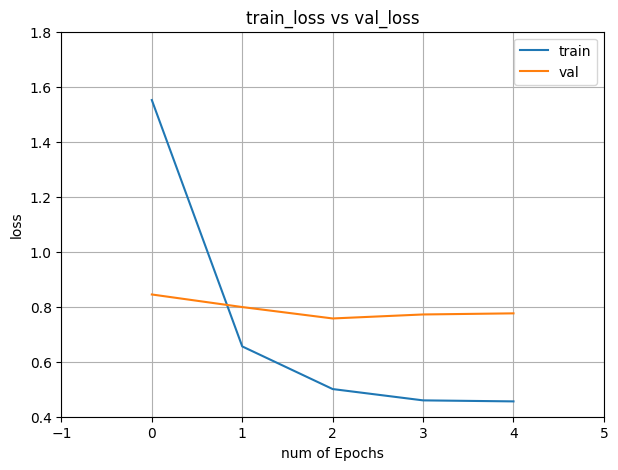

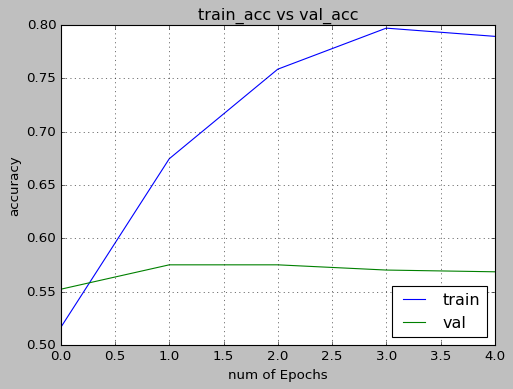

In [ ]:

epochs = 5
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])

In [ ]:

train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="training")

val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="validation"
                                          )

Found 1429 images belonging to 2 classes.
Found 612 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import Xception


tf.keras.backend.clear_session()

xception_model = Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

xception_model.trainable = False

model = Sequential([
    xception_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(2, activation='sigmoid')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization_4 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                         

In [ ]:
hist =  model.fit_generator(train,
                    epochs=10,
                    callbacks=[lr_callbacks],
                    validation_data=val)

<ipython-input-34-5353d5103043>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist =  model.fit_generator(train,


Epoch 1/10
15/15 [==============================] - 43s 2s/step - loss: 0.9506 - accuracy: 0.5696 - val_loss: 0.7176 - val_accuracy: 0.5131 - lr: 0.0010
Epoch 2/10
15/15 [==============================] - 20s 1s/step - loss: 0.6151 - accuracy: 0.6991 - val_loss: 0.7260 - val_accuracy: 0.5131 - lr: 0.0010
Epoch 3/10
15/15 [==============================] - 25s 2s/step - loss: 0.5187 - accuracy: 0.7516 - val_loss: 0.7492 - val_accuracy: 0.4739 - lr: 0.0010
Epoch 4/10
15/15 [==============================] - 19s 1s/step - loss: 0.4347 - accuracy: 0.7992 - val_loss: 0.7421 - val_accuracy: 0.4902 - lr: 1.0000e-04
Epoch 5/10
15/15 [==============================] - 20s 1s/step - loss: 0.3976 - accuracy: 0.8209 - val_loss: 0.7411 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 6/10
15/15 [==============================] - 20s 1s/step - loss: 0.3975 - accuracy: 0.8139 - val_loss: 0.7573 - val_accuracy: 0.4967 - lr: 1.0000e-04
Epoch 7/10
15/15 [==============================] - 20s 1s/step - loss

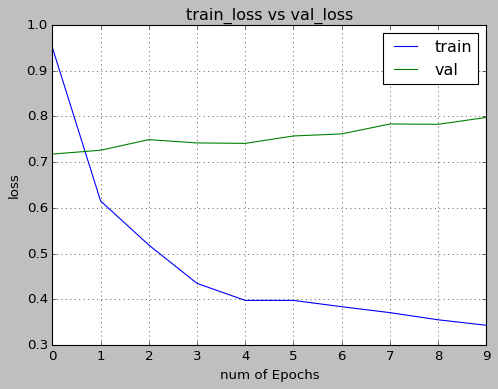

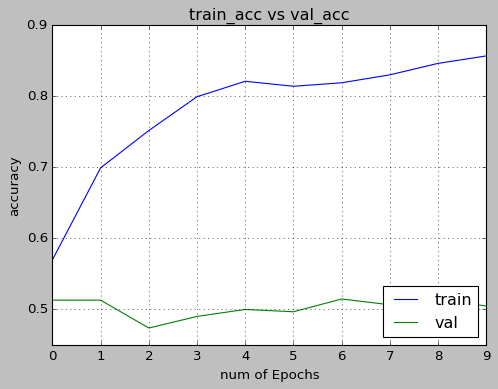

In [ ]:

epochs = 10
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])

In [ ]:
predictions = model.predict_generator(val)

<ipython-input-36-7c68dd12cc9d>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(val)


In [ ]:
model.save('Xception.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


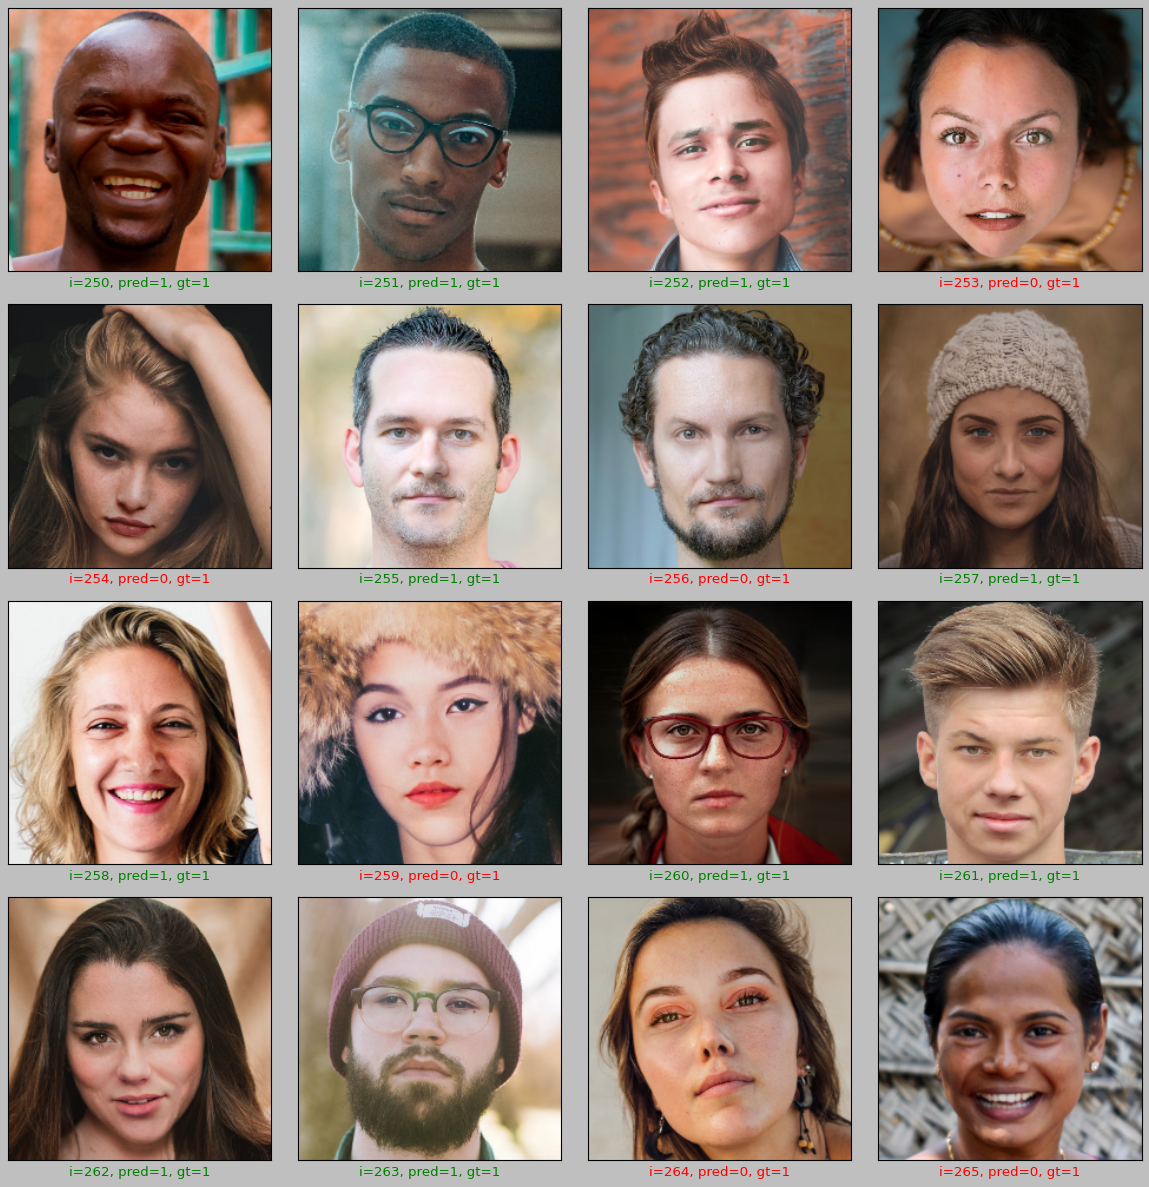

In [ ]:

val_path = "/kaggle/input/real-vs-fake-faces/"

plt.figure(figsize=(15,15))

start_index = 250

for i in range(16):
  plt.subplot(4,4, i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  preds = np.argmax(predictions[[start_index+i]])

  gt = val.filenames[start_index+i][9:13]


  if gt == "fake":
    gt = 0
  else:
    gt = 1

  if preds != gt:
    col ="r"
  else:
    col = "g"

  plt.xlabel('i={}, pred={}, gt={}'.format(start_index+i,preds,gt),color=col)
  plt.imshow(load_img(val_path+val.filenames[start_index+i]))
  plt.tight_layout()

plt.show()